In [7]:
import os
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [8]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.astype(np.float32)/255.0
x_test = x_test.astype(np.float32)/255.0

11493376/11490434 [==============================] - 0s 0us/step


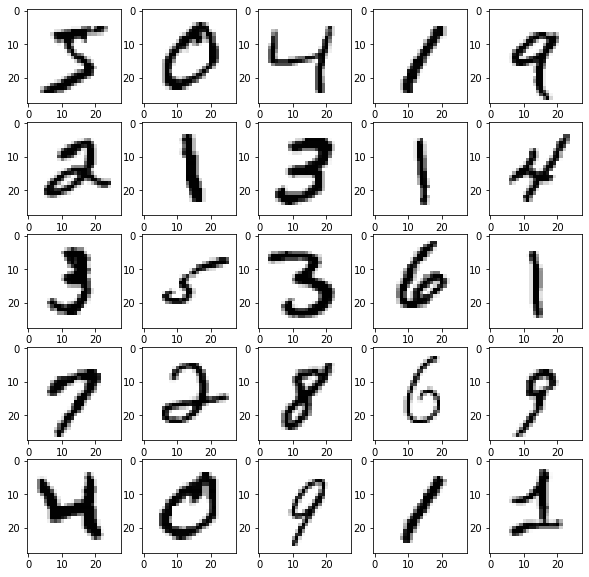

In [9]:
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.grid(False)
  plt.imshow(x_train[i], cmap=plt.cm.binary)

In [41]:
discriminator = keras.models.Sequential([
                                         keras.layers.Conv2D(64, 3, strides=2, input_shape=[28,28,1]),
                                         keras.layers.LeakyReLU(),
                                         keras.layers.BatchNormalization(),
                                         keras.layers.Conv2D(128, 5, strides=2),
                                         keras.layers.LeakyReLU(),
                                         keras.layers.BatchNormalization(),
                                         keras.layers.Conv2D(256, 5, strides=2),
                                         keras.layers.LeakyReLU(),
                                         keras.layers.BatchNormalization(),
                                         keras.layers.Flatten(),
                                         keras.layers.Dense(1, activation='sigmoid')
])

In [42]:
discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
discriminator.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 13, 13, 64)        640       
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 13, 13, 64)        0         
_________________________________________________________________
batch_normalization_37 (Batc (None, 13, 13, 64)        256       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 5, 5, 128)         204928    
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 5, 5, 128)         0         
_________________________________________________________________
batch_normalization_38 (Batc (None, 5, 5, 128)         512       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 1, 1, 256)       

In [55]:
generator = keras.models.Sequential([
                                     keras.layers.Dense(256, activation='relu', input_shape=(1, )),
                                     keras.layers.Reshape((1,1,256)),
                                     keras.layers.Conv2DTranspose(256, 5, activation='relu'),
                                     keras.layers.BatchNormalization(),
                                     keras.layers.Conv2DTranspose(128, 5, activation='relu'),
                                     keras.layers.BatchNormalization(),
                                     keras.layers.Conv2DTranspose(64, 5, activation='relu'),
                                     keras.layers.BatchNormalization(),
                                     keras.layers.Conv2DTranspose(32, 5, activation='relu'),
                                     keras.layers.BatchNormalization(),
                                     keras.layers.Conv2DTranspose(1, 12, activation='sigmoid')                                                                                                               
])
generator.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 256)               512       
_________________________________________________________________
reshape_15 (Reshape)         (None, 1, 1, 256)         0         
_________________________________________________________________
conv2d_transpose_73 (Conv2DT (None, 5, 5, 256)         1638656   
_________________________________________________________________
batch_normalization_70 (Batc (None, 5, 5, 256)         1024      
_________________________________________________________________
conv2d_transpose_74 (Conv2DT (None, 9, 9, 128)         819328    
_________________________________________________________________
batch_normalization_71 (Batc (None, 9, 9, 128)         512       
_________________________________________________________________
conv2d_transpose_75 (Conv2DT (None, 13, 13, 64)      

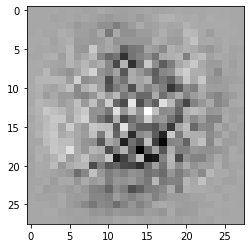

In [56]:
noise = np.random.randn(1,1)
gen_img = generator.predict(noise)[0]
plt.figure()
plt.imshow(np.reshape(gen_img, (28,28)),cmap='binary')
plt.show()

In [66]:
input_layer = keras.layers.Input(shape=(1,))
gen_out = generator(input_layer)
disc_out = discriminator(gen_out)

gan = keras.Model(
    input_layer,
    disc_out
)

discriminator.trainable = False

gan.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
gan.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 1)]               0         
_________________________________________________________________
sequential_19 (Sequential)   (None, 28, 28, 1)         2721121   
_________________________________________________________________
sequential_10 (Sequential)   (None, 1)                 1027073   
Total params: 3,748,194
Trainable params: 2,720,161
Non-trainable params: 1,028,033
_________________________________________________________________


In [68]:
epochs=25
batch_size=128
steps_per_epochs = 107

print('Steps per epochs=',steps_per_epochs)

Steps per epochs= 107


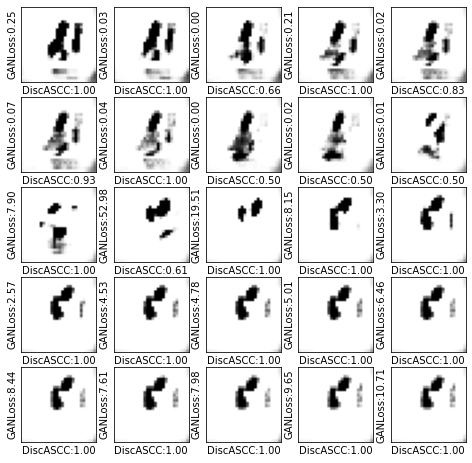

In [69]:
dp = DynamicPlot(plt,5,5, (8,8))

for e in range(0, epochs):
    dp.start_of_epoch(e)
    for step in range(0, steps_per_epochs):
        true_examples = x[int(batch_size/2)*step:int(batch_size/2)*(step+1)]
        true_examples = np.reshape(true_examples, (true_examples.shape[0],28,28,1))
        
        noise = np.random.randn(int(batch_size/2),1)
        gen_examples = generator.predict(noise)
        
        x_batch = np.concatenate([gen_examples, true_examples], axis=0)
        y_batch = np.array([0]*int(batch_size/2) + [1]*int(batch_size/2))
        
        indices = np.random.choice(range(batch_size), batch_size, replace = False)
        
        x_batch = x_batch[indices]
        y_batch = y_batch[indices]
        
        discriminator.trainable = True 
        discriminator.train_on_batch(x_batch, y_batch)
        discriminator.trainable = False
        
        loss, _ = gan.train_on_batch(noise, np.ones((int(batch_size/2), 1)))
        _, acc = discriminator.evaluate(x_batch, y_batch, verbose= False)
        
    noise = np.random.randn(1,1)
    gen_image = generator.predict(noise)[0]
    gen_image = np.reshape(gen_image, (28,28))
    dp.end_of_epoch(gen_image, 'binary','DiscASCC:{:.2f}'.format(acc),'GANLoss:{:.2f}'.format(loss))

In [62]:
class DynamicPlot:
    def __init__(self, plt, rows, cols, figsize):
        
        self.rows = rows
        self.cols = cols

        self.plt = plt 

        self.fig = self.plt.figure(figsize=figsize)
        self.plt.ion()
    
    def draw_fig(self):
        self.fig.show()
        self.fig.canvas.draw()
    
    def start_of_epoch(self, epoch):
        self.ax = self.plt.subplot(self.rows, self.cols, 1 + epoch)
        
    def end_of_epoch(self, image, cmap, xlabel, ylabel):
        self.ax.imshow(image, cmap=cmap)
        self.ax.set_xlabel(xlabel)
        self.ax.set_ylabel(ylabel)
        self.ax.set_xticks([])
        self.ax.set_yticks([])
        self.draw_fig()

In [70]:
###EX

In [ ]:
discriminator  =  Sequential([
    Conv2D(64, 3, strides=2, input_shape=(28,28,1) ),
    LeakyReLU(),
    BatchNormalization(),
    Conv2D(128, 5, strides=2),
    LeakyReLU(),
    BatchNormalization(),
    Conv2D(256, 5, strides=2),
    LeakyReLU(),
    BatchNormalization(),   
    Flatten(),
    Dense(1, activation='sigmoid')
])
opt = tf.keras.optimizers.Adam(lr=2e-4, beta_1 = 0.5)
discriminator.compile(loss='binary_crossentropy',optimizer=opt, metrics=['accuracy'])
discriminator.summary()

In [ ]:
generator = Sequential([
    Dense(256, activation='relu', input_shape=(1,)),
    Reshape((1,1,256)),
    Conv2DTranspose(256, 5 , activation = 'relu'),
    BatchNormalization(),
    Conv2DTranspose(128, 5 , activation = 'relu'),
    BatchNormalization(),
    Conv2DTranspose(64, 5 ,strides = 2, activation = 'relu'),
    BatchNormalization(),
    Conv2DTranspose(32, 5 , activation = 'relu'),
    BatchNormalization(),
    Conv2DTranspose(1, 4 , activation='sigmoid')  
])
generator.summary()